In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20)
import matplotlib.pyplot as plt
import seaborn as sns

import json
import glob
import statistics

import scipy.stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, r2_score
from scipy.special import softmax

In [2]:
path = "/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior"
output_csv_file = "flanker_class_supervised_results/outputs/test_outputs.csv"

# One model

In [3]:
model_path = "2023-09-25_SFinferior_1/11-45-19_72"

In [4]:
bdd = pd.read_csv(f"{path}/{model_path}/{output_csv_file}", index_col=0)

In [5]:
bdd.head()

,labels,dim1,dim2
ID,,,
100206,1,0.172009,0.805077
102513,0,0.190825,0.773158
103212,0,0.857192,0.132026
105620,1,0.243623,0.689641
107220,0,0.885225,0.112811


In [6]:
bdd[["softmax1", "proba"]] = softmax(bdd[["dim1", "dim2"]], axis=1)
bdd.head()

,labels,dim1,dim2,softmax1,proba
ID,,,,,
100206,1,0.172009,0.805077,0.346815,0.653185
102513,0,0.190825,0.773158,0.358396,0.641604
103212,0,0.857192,0.132026,0.673744,0.326256
105620,1,0.243623,0.689641,0.390308,0.609692
107220,0,0.885225,0.112811,0.684043,0.315957


In [7]:
roc_auc_score(bdd.labels, bdd.proba)

0.5388167388167387

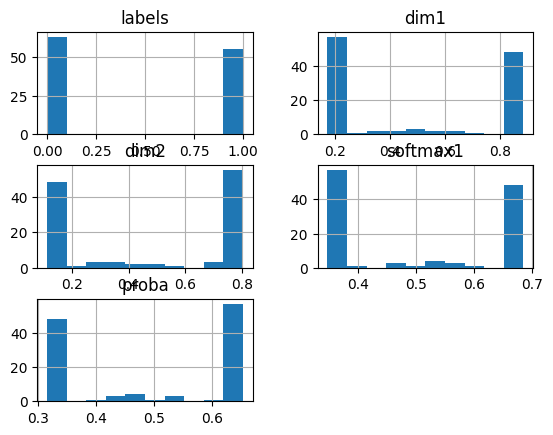

In [8]:
hist = bdd.hist()

<Axes: xlabel='proba', ylabel='Count'>

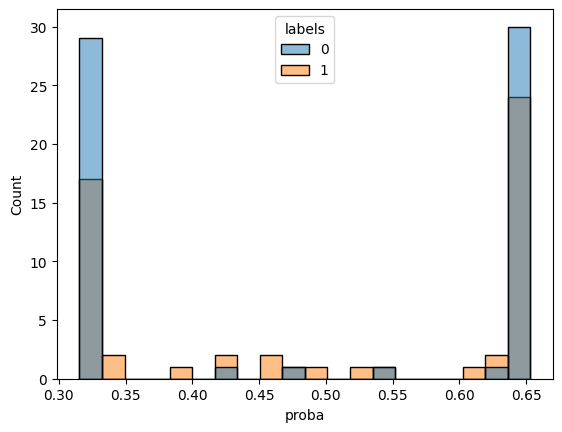

In [9]:
sns.histplot(data=bdd, x="proba", hue="labels", bins=20)

# Ensemble model for SFinferior

In [10]:
def get_ensemble_auc_statistics(bdd_filename, nb_estimators, nb_bootstraps):
    """Computes ensemble AUC and std_auc.
    
    Reads bdd, computes crtierion_end and sort by criterion_end, ascending.
    Then, computes average of nb_estimators best models"""

    # Reads bdd, computes crtierion_end and sort by criterion_end, ascending.
    bdd = pd.read_csv(bdd_filename, index_col=0)
    bdd["criterion"] = abs(bdd["best_val_auc"] - bdd["best_train_auc"]) + 2*(1-bdd["best_val_auc"])
    bdd["criterion_end_old"] = abs(bdd["val_auc"] - bdd["train_auc"]) + 2*(1-bdd["val_auc"])
    bdd["criterion_end"] = bdd.apply(lambda x: 2*(1-x["val_auc"]) + max(-x["val_auc"] + x["train_auc"], 0), axis=1)
    bdd = bdd.sort_values(by=['criterion_end'], ascending=True)

    # Computes average of nb_estimators best models
    output_bdd = pd.DataFrame()
    output_csv_file = "flanker_class_supervised_results/outputs/test_outputs.csv"
    for i in range(nb_estimators):
        model_path = bdd.iloc[i,0] # takes model_path column
        output = pd.read_csv(f"{model_path}/{output_csv_file}", index_col=0)
        if i == 0:
            output_bdd["label"] = output["labels"]
        output[["softmax1", "proba"]] = softmax(output[["dim1", "dim2"]], axis=1)
        output_bdd[f"p{i}"] = output["proba"]
    output_bdd["avg"] = output_bdd.iloc[:, 1:(nb_estimators+1)].mean(axis=1)

    # Computes AUC of ensemble average
    auc = roc_auc_score(output_bdd.label, output_bdd.avg)

    # Computes bootstrap stdandard deviation of ensemble average
    auc_bootstrap = []
    for i in range(nb_bootstraps):
        sampling = np.random.choice(range(1, (nb_estimators+1)), size=nb_estimators, replace=True)
        temp = output_bdd.iloc[:,sampling].copy(deep=True)
        temp["label"] = output_bdd["label"]
        temp["avg"] = temp.iloc[:,0:(nb_estimators)].mean(axis=1)
        # print(temp.head())
        auc_bootstrap.append(roc_auc_score(temp.label, temp.avg))
    std_auc = statistics.stdev(auc_bootstrap)

    return auc, std_auc
    

In [11]:
get_ensemble_auc_statistics("/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-25_SFinferior.csv", 5, 1000)

(0.6164502164502164, 0.0021501968825967123)

In [12]:
bdd = pd.read_csv("/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-25_SFinferior.csv", index_col=0)
bdd = bdd.sort_values(by=['best_test_auc'], ascending=False)
csv_output_file = "flanker_class_supervised_results/outputs/test_outputs.csv"

In [13]:
bdd.head()

,model_path,train_auc,val_auc,test_auc,best_train_auc,best_val_auc,best_test_auc,drop_rate,gamma,lr,train_loss
11,/neurospin/dico/data/deep_folding/history/2023...,0.542464,0.624386,0.623232,0.543087,0.624223,0.623954,0.118628,0.773751,0.001018,138.642960
14,/neurospin/dico/data/deep_folding/history/2023...,0.536747,0.632406,0.514286,0.535523,0.635025,0.622511,0.232445,0.785578,0.001710,138.588120
37,/neurospin/dico/data/deep_folding/history/2023...,0.543695,0.640262,0.618903,0.543906,0.633879,0.618615,0.213467,0.789672,0.001275,138.638351
42,/neurospin/dico/data/deep_folding/history/2023...,0.549765,0.625532,0.611255,0.547962,0.627005,0.615729,0.195508,0.901434,0.001534,138.581528
7,/neurospin/dico/data/deep_folding/history/2023...,0.544161,0.635516,0.618470,0.544634,0.634697,0.615440,0.216597,0.941961,0.000520,138.590683


In [14]:
bdd["criterion"] = abs(bdd["best_val_auc"] - bdd["best_train_auc"]) + 2*(1-bdd["best_val_auc"])
bdd["criterion_end_old"] = abs(bdd["val_auc"] - bdd["train_auc"]) + 2*(1-bdd["val_auc"])
bdd["criterion_end"] = bdd.apply(lambda x: 2*(1-x["val_auc"]) + max(-x["val_auc"] + x["train_auc"], 0), axis=1)
bdd = bdd.sort_values(by=['criterion_end'], ascending=True)
bdd.head()

,model_path,train_auc,val_auc,test_auc,best_train_auc,best_val_auc,best_test_auc,drop_rate,gamma,lr,train_loss,criterion,criterion_end_old,criterion_end
28,/neurospin/dico/data/deep_folding/history/2023...,0.541096,0.649427,0.595815,0.541284,0.652373,0.593362,0.131310,0.759435,0.006698,138.628662,0.806343,0.809476,0.701146
12,/neurospin/dico/data/deep_folding/history/2023...,0.548127,0.648773,0.604618,0.547752,0.645336,0.600000,0.088512,0.972547,0.003687,138.670090,0.806913,0.803100,0.702455
1,/neurospin/dico/data/deep_folding/history/2023...,0.545664,0.648282,0.614141,0.541697,0.646318,0.606349,0.119366,0.773338,0.006838,138.619629,0.811985,0.806055,0.703437
30,/neurospin/dico/data/deep_folding/history/2023...,0.557923,0.645172,0.612121,0.556285,0.648445,0.605772,0.285314,0.917592,0.000498,138.645721,0.795270,0.796906,0.709656
37,/neurospin/dico/data/deep_folding/history/2023...,0.543695,0.640262,0.618903,0.543906,0.633879,0.618615,0.213467,0.789672,0.001275,138.638351,0.822215,0.816043,0.719476


In [15]:
bdd["model_path"].tolist()[:5]

['/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-26_SFinferior/04-11-11_122',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-25_SFinferior_1/19-08-59_124',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-25_SFinferior_1/12-19-10_233',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-26_SFinferior/05-16-46_6',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-26_SFinferior/08-58-41_230']

In [16]:
bdd.iloc[0,0]

'/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-26_SFinferior/04-11-11_122'

In [17]:
output_bdd = pd.DataFrame()
nb_estimators = 5
for i in range(nb_estimators):
    model_path = bdd.iloc[i,0] # takes model_path column
    print(model_path)
    output = pd.read_csv(f"{model_path}/{output_csv_file}", index_col=0)
    if i == 0:
        output_bdd["label"] = output["labels"]
    output[["softmax1", "proba"]] = softmax(output[["dim1", "dim2"]], axis=1)
    output_bdd[f"p{i}"] = output["proba"]
output_bdd["avg"] = output_bdd.iloc[:, 1:(nb_estimators+1)].mean(axis=1)
output_bdd.head()

/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-26_SFinferior/04-11-11_122
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-25_SFinferior_1/19-08-59_124
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-25_SFinferior_1/12-19-10_233
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-26_SFinferior/05-16-46_6
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-26_SFinferior/08-58-41_230


,label,p0,p1,p2,p3,p4,avg
ID,,,,,,,
100206,1,0.502517,0.497091,0.501183,0.500858,0.501056,0.500541
102513,0,0.502519,0.497098,0.501230,0.501261,0.501051,0.500632
103212,0,0.502524,0.497104,0.501532,0.503644,0.501178,0.501196
105620,1,0.502516,0.497093,0.501140,0.500145,0.501029,0.500385
107220,0,0.502505,0.497067,0.500911,0.498099,0.500914,0.499899


In [18]:
roc_auc_score(output_bdd.label, output_bdd.avg)

0.6164502164502164

In [19]:
auc_bootstrap = []
nb_bootstraps = 1000
for i in range(nb_bootstraps):
    sampling = np.random.choice(range(1, (nb_estimators+1)), size=nb_estimators, replace=True)
    temp = output_bdd.iloc[:,sampling].copy(deep=True)
    temp["label"] = output_bdd["label"]
    temp["avg"] = temp.iloc[:,0:(nb_estimators)].mean(axis=1)
    # print(temp.head())
    auc_bootstrap.append(roc_auc_score(temp.label, temp.avg))
print(auc_bootstrap)

[0.6152958152958152, 0.6126984126984126, 0.6161616161616162, 0.6144300144300144, 0.6126984126984127, 0.6164502164502164, 0.6132756132756132, 0.6144300144300144, 0.615007215007215, 0.6132756132756133, 0.6121212121212121, 0.6121212121212121, 0.6126984126984127, 0.6135642135642135, 0.6138528138528138, 0.6141414141414141, 0.6141414141414142, 0.6138528138528139, 0.6164502164502164, 0.6164502164502164, 0.612987012987013, 0.6141414141414141, 0.6121212121212122, 0.6135642135642135, 0.6155844155844156, 0.6178932178932179, 0.6138528138528139, 0.6126984126984127, 0.6152958152958152, 0.6098124098124098, 0.6161616161616162, 0.6118326118326118, 0.6161616161616161, 0.6155844155844156, 0.6144300144300144, 0.6121212121212122, 0.6144300144300144, 0.6121212121212122, 0.617027417027417, 0.6190476190476191, 0.6144300144300144, 0.6138528138528138, 0.6135642135642135, 0.6144300144300144, 0.6126984126984127, 0.6132756132756133, 0.6126984126984127, 0.6124098124098124, 0.6158730158730159, 0.6126984126984127, 0.

In [20]:
statistics.stdev(auc_bootstrap)

0.0019313890833259069

(array([  1.,   0.,   0.,   3.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
         17.,   7., 101., 347., 206., 209.,  95.,   9.,   3.]),
 array([0.595671  , 0.59688312, 0.59809524, 0.59930736, 0.60051948,
        0.6017316 , 0.60294372, 0.60415584, 0.60536797, 0.60658009,
        0.60779221, 0.60900433, 0.61021645, 0.61142857, 0.61264069,
        0.61385281, 0.61506494, 0.61627706, 0.61748918, 0.6187013 ,
        0.61991342]),
 <BarContainer object of 20 artists>)

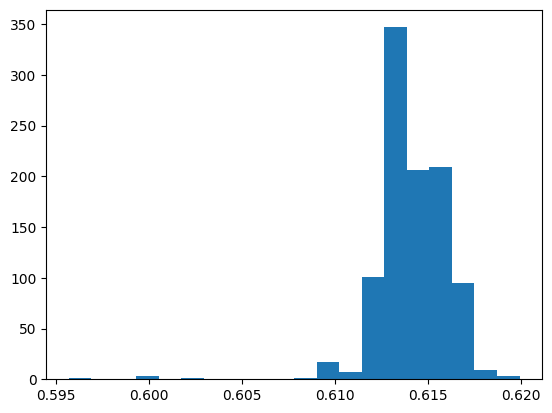

In [21]:
plt.hist(auc_bootstrap, bins=20)

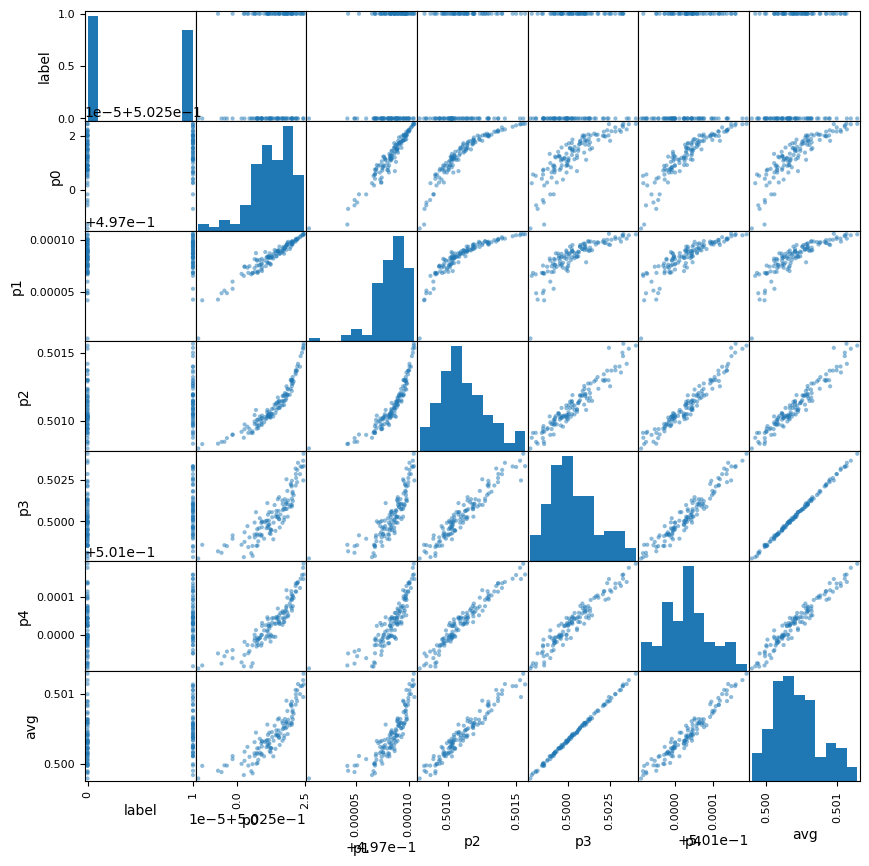

In [22]:
plt_ = pd.plotting.scatter_matrix(output_bdd, figsize=(10,10))

# Putting models together

In [23]:
def confidence_interval(data, percentage=95):
    if percentage == 95:
        z = 1.96
    else:
        raise(ValueError("frero..."))
    
    std = np.std(data)
    N = data.shape[0]

    diff = z * std/np.sqrt(N)

    return diff

In [24]:
json_regions = "/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Input/sulci_regions_gridsearch.json"
result_file = "/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/flanker_per_region_on_HCP.ods" 
bdd_path = "/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary"

In [25]:
with open(json_regions) as f:
    regions = json.load(f)

In [26]:
res = pd.read_excel(result_file)
res = res.rename(columns = {"Region (sulci_region_gridsearch)": "region",
                            "Region name without ‘.’ (for yaml configuration)": "region_simple_name"}).drop(res.columns[3:11], axis=1)
res = res.assign(bdd=None)

res = res.dropna(subset = ['AUC'])
res.head()

,region,region_simple_name,Lobe,AUC,std_auc,AUC-1,std_auc-1,AUC-2,std_auc-2,AUC_narrow,std_auc_narrow,AUC-2_narrow,std_auc-2_narrow,bdd
0,CINGULATE.,cingulate,frontal,0.559,0.019,0.560,0.019,0.546,0.028,0.553,0.008,0.552,0.008,None
1,S.F.inf.-BROCA-S.Pe.C.inf.,BROCA,frontal,0.494,0.023,0.488,0.027,0.488,0.014,NaN,NaN,NaN,NaN,None
2,Sc.Cal.-S.Li.,pericalcarine,occipital,0.554,0.032,0.554,0.032,0.535,0.030,NaN,NaN,NaN,NaN,None
3,S.T.s.,STs,temporal,0.516,0.041,0.530,0.036,0.516,0.041,NaN,NaN,NaN,NaN,None
4,S.T.s.br.,STs_br,temporal,0.468,0.009,0.468,0.009,0.468,0.009,NaN,NaN,NaN,NaN,None


In [27]:
list_region_simple = res.region_simple_name.tolist()

In [28]:
summary_path = "/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary"
# we get the databases based on region names
for region in list_region_simple:
    print(glob.glob(f"{summary_path}/bdd_*[0-9]_{region}.csv"))

['/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-11_cingulate.csv']
['/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-12_BROCA.csv']
['/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-21_pericalcarine.csv']
['/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-20_STs.csv']
['/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-27_STs_br.csv']
['/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-26_central.csv']
['/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-14_central_precentral.csv']
['/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-19_central_postcentral.csv']
['/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-28_precentra

# Loop over bdd

In [29]:
def return_bdd(region_simple_name):
    csv_file = glob.glob(f"{bdd_path}/bdd_*[0-9]_{region_simple_name}.csv")
    if len(csv_file):
        print(csv_file[0])
        return pd.read_csv(csv_file[0], index_col=0)
    else: 
        print(f"{region_simple_name} without csv")
        return pd.DataFrame()

In [30]:
def return_bdd_file_name(region_simple_name):
    csv_file = glob.glob(f"{bdd_path}/bdd_*[0-9]_{region_simple_name}.csv")
    if len(csv_file):
        return csv_file[0]
    else: 
        print(f"{region_simple_name} without csv")
        return ""

In [31]:
def compute_logp(auc, std_auc):
    p = scipy.stats.ttest_ind_from_stats(mean1=auc, 
                              std1=std_auc, 
                              nobs1=5, 
                              mean2=0.5, 
                              std2=0, 
                              nobs2=2, 
                              alternative='greater',
                              equal_var=False)[1]
    return -np.log10(p)

In [32]:
def process_bdd(row):

    print(row.bdd)
    bdd = row.bdd
    res_d = {}

    if bdd.empty:
        res_d["AUC_criterion"] = np.nan
        res_d['logp_AUC'] = np.nan
        res_d["std_auc_criterion"] = np.nan
        res_d["AUC_old_criterion"] = np.nan
        res_d["std_auc_old_criterion"] = np.nan
        res_d["AUC_best_val"] = np.nan
        res_d["std_auc_best_val"] = np.nan
        res_d["AUC_best_model"] = np.nan
        res_d["std_auc_best_model"] = np.nan
        res_d['log_lr'] = np.nan
        res_d['std_log_lr'] = np.nan
    else:
        res_d["AUC_criterion"] = np.nan
        res_d['logp_AUC'] = np.nan
        res_d["std_auc_criterion"] = np.nan
        res_d["AUC_old_criterion"] = np.nan
        res_d["std_auc_old_criterion"] = np.nan
        res_d["AUC_best_val"] = np.nan
        res_d["std_auc_best_val"] = np.nan
        res_d["AUC_best_model"] = np.nan
        res_d["std_auc_best_model"] = np.nan
        res_d['log_lr'] = np.nan
        res_d['std_log_lr'] = np.nan
        # Compute criterions
        bdd["criterion"] = bdd.apply(lambda x: 2*(1-x["val_auc"]) + max(-x["val_auc"] + x["train_auc"], 0), axis=1)
        bdd["criterion_old"] = abs(bdd["val_auc"] - bdd["train_auc"]) + 2*(1-bdd["val_auc"])
        bdd["criterion_best"] = abs(bdd["best_val_auc"] - bdd["best_train_auc"]) + 2*(1-bdd["best_val_auc"])

        # Make bdds rearranged according to criterion
        best_end = bdd.sort_values(by=['criterion'], ascending=True)[:5]
        best_end_old = bdd.sort_values(by=['criterion_old'], ascending=True)[:5]
        best_val_end = bdd.sort_values(by=['val_auc'], ascending=False)[:5]
        best_best = bdd.sort_values(by=['criterion_best'], ascending=True)[:5]


        # Compute AUCs
        res_d["AUC_criterion"] = best_end['test_auc'].mean()
        res_d["std_auc_criterion"] = best_end['test_auc'].std()
        res_d['logp_AUC_criterion'] = compute_logp(res_d["AUC_criterion"], res_d["std_auc_criterion"])
        res_d["AUC_old_criterion"] = best_end_old['test_auc'].mean()
        res_d["std_auc_old_criterion"] = best_end_old['test_auc'].std()
        res_d['logp_AUC_old_criterion'] = compute_logp(res_d["AUC_old_criterion"], res_d["std_auc_old_criterion"])
        res_d["AUC_best_val"] = best_val_end['test_auc'].mean()
        res_d["std_auc_best_val"] = best_val_end['test_auc'].std()
        res_d['logp_AUC_best_val'] = compute_logp(res_d["AUC_best_val"], res_d["std_auc_best_val"])
        res_d["AUC_best_model"] = best_best['best_test_auc'].mean()
        res_d["std_auc_best_model"] = best_best['best_test_auc'].std()
        res_d['logp_AUC_best_model'] = compute_logp(res_d["AUC_best_model"], res_d["std_auc_best_model"])
        res_d["log_lr"] = (-np.log10(best_end['lr'])).mean()
        res_d["std_log_lr"] = (-np.log10(best_end['lr'])).std()


    return pd.Series(res_d)

In [33]:
res["bdd"] = res["region_simple_name"].apply(return_bdd)

/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-11_cingulate.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-12_BROCA.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-21_pericalcarine.csv


/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-20_STs.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-27_STs_br.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-26_central.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-14_central_precentral.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-19_central_postcentral.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-28_precentral.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-28_postcentral.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-21_SOr.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-28_SOr_olfactif.csv
/neurospin/dico/data/deep_fol

In [34]:
res["bdd_file_name"] = res["region_simple_name"].apply(return_bdd_file_name)

In [35]:
res["bdd_file_name"].tolist()

['/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-11_cingulate.csv',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-12_BROCA.csv',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-21_pericalcarine.csv',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-20_STs.csv',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-27_STs_br.csv',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-26_central.csv',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-14_central_precentral.csv',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-19_central_postcentral.csv',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-28_precentra

In [36]:
res = res.join(res.apply(process_bdd, axis="columns"))


                                           model_path  train_auc   val_auc  \
0   /neurospin/dico/data/deep_folding/history/2023...   0.992984  0.653191   
1   /neurospin/dico/data/deep_folding/history/2023...   0.557359  0.588707   
2   /neurospin/dico/data/deep_folding/history/2023...   0.599898  0.607856   
3   /neurospin/dico/data/deep_folding/history/2023...   1.000000  0.621604   
4   /neurospin/dico/data/deep_folding/history/2023...   0.998265  0.615712   
..                                                ...        ...       ...   
36  /neurospin/dico/data/deep_folding/history/2023...   0.662320  0.547954   
37  /neurospin/dico/data/deep_folding/history/2023...   0.541615  0.516039   
38  /neurospin/dico/data/deep_folding/history/2023...   0.500000  0.500000   
39  /neurospin/dico/data/deep_folding/history/2023...   0.580322  0.576432   
40  /neurospin/dico/data/deep_folding/history/2023...   0.996717  0.620622   

    test_auc  best_train_auc  best_val_auc  best_test_auc  drop

In [37]:
res.head()

,region,region_simple_name,Lobe,AUC,std_auc,AUC-1,std_auc-1,AUC-2,std_auc-2,AUC_narrow,...,AUC_best_val,std_auc_best_val,AUC_best_model,std_auc_best_model,log_lr,std_log_lr,logp_AUC_criterion,logp_AUC_old_criterion,logp_AUC_best_val,logp_AUC_best_model
0,CINGULATE.,cingulate,frontal,0.559,0.019,0.560,0.019,0.546,0.028,0.553,...,0.546378,0.027564,0.561097,0.039295,2.653998,0.434632,2.970499,2.970499,2.005764,1.895694
1,S.F.inf.-BROCA-S.Pe.C.inf.,BROCA,frontal,0.494,0.023,0.488,0.027,0.488,0.014,NaN,...,0.487792,0.013850,0.508369,0.024027,2.386500,0.193476,0.153070,0.092444,0.026882,0.620193
2,Sc.Cal.-S.Li.,pericalcarine,occipital,0.554,0.032,0.554,0.032,0.535,0.030,NaN,...,0.535296,0.030075,0.560029,0.028885,2.547291,0.483520,2.002862,2.002862,1.533586,2.315037
3,S.T.s.,STs,temporal,0.516,0.041,0.530,0.036,0.516,0.041,NaN,...,0.516248,0.040687,0.515556,0.041121,3.205652,0.280429,0.675366,1.243215,0.675366,0.652422
4,S.T.s.br.,STs_br,temporal,0.468,0.009,0.468,0.009,0.468,0.009,NaN,...,0.468341,0.009148,0.482482,0.031245,3.000318,0.329289,0.000326,0.000326,0.000326,0.065055


In [38]:
def get_ensemble_auc_statistics_df(x):
    print(f"processing {x.region_simple_name}", end='... ')
    x["AUC_ensemble"], x["std_auc_ensemble"] = get_ensemble_auc_statistics(x["bdd_file_name"], 5, 1000)
    print("done")
    return x

In [39]:
res = res.apply(get_ensemble_auc_statistics_df, axis=1)
res.head()

processing cingulate... done
processing BROCA... done
processing pericalcarine... done
processing STs... done
processing STs_br... done
processing central... done
processing central_precentral... done
processing central_postcentral... done
processing precentral... done
processing postcentral... done
processing SOr... done
processing SOr_olfactif... done
processing FCMpost... done
processing SFmedian... done
processing SFintermediate... done
processing SFinferior... done
processing SFinternal... done
processing occipito_temporal... done
processing occipital... done
processing intraparietal... done
processing internal_parietal... done
processing lobule_parietal_sup... done
processing inferior_temporal... done
processing fissure_collateral... done
processing fissure_lateral... done
processing fissure_parieto_occipital... done
processing fronto-parietal_medial_face... done


,region,region_simple_name,Lobe,AUC,std_auc,AUC-1,std_auc-1,AUC-2,std_auc-2,AUC_narrow,...,AUC_best_model,std_auc_best_model,log_lr,std_log_lr,logp_AUC_criterion,logp_AUC_old_criterion,logp_AUC_best_val,logp_AUC_best_model,AUC_ensemble,std_auc_ensemble
0,CINGULATE.,cingulate,frontal,0.559,0.019,0.560,0.019,0.546,0.028,0.553,...,0.561097,0.039295,2.653998,0.434632,2.970499,2.970499,2.005764,1.895694,0.571717,0.008981
1,S.F.inf.-BROCA-S.Pe.C.inf.,BROCA,frontal,0.494,0.023,0.488,0.027,0.488,0.014,NaN,...,0.508369,0.024027,2.386500,0.193476,0.153070,0.092444,0.026882,0.620193,0.490332,0.012209
2,Sc.Cal.-S.Li.,pericalcarine,occipital,0.554,0.032,0.554,0.032,0.535,0.030,NaN,...,0.560029,0.028885,2.547291,0.483520,2.002862,2.002862,1.533586,2.315037,0.505628,0.026941
3,S.T.s.,STs,temporal,0.516,0.041,0.530,0.036,0.516,0.041,NaN,...,0.515556,0.041121,3.205652,0.280429,0.675366,1.243215,0.675366,0.652422,0.531890,0.015188
4,S.T.s.br.,STs_br,temporal,0.468,0.009,0.468,0.009,0.468,0.009,NaN,...,0.482482,0.031245,3.000318,0.329289,0.000326,0.000326,0.000326,0.065055,0.460895,0.011807


In [40]:
res.head()

,region,region_simple_name,Lobe,AUC,std_auc,AUC-1,std_auc-1,AUC-2,std_auc-2,AUC_narrow,...,AUC_best_model,std_auc_best_model,log_lr,std_log_lr,logp_AUC_criterion,logp_AUC_old_criterion,logp_AUC_best_val,logp_AUC_best_model,AUC_ensemble,std_auc_ensemble
0,CINGULATE.,cingulate,frontal,0.559,0.019,0.560,0.019,0.546,0.028,0.553,...,0.561097,0.039295,2.653998,0.434632,2.970499,2.970499,2.005764,1.895694,0.571717,0.008981
1,S.F.inf.-BROCA-S.Pe.C.inf.,BROCA,frontal,0.494,0.023,0.488,0.027,0.488,0.014,NaN,...,0.508369,0.024027,2.386500,0.193476,0.153070,0.092444,0.026882,0.620193,0.490332,0.012209
2,Sc.Cal.-S.Li.,pericalcarine,occipital,0.554,0.032,0.554,0.032,0.535,0.030,NaN,...,0.560029,0.028885,2.547291,0.483520,2.002862,2.002862,1.533586,2.315037,0.505628,0.026941
3,S.T.s.,STs,temporal,0.516,0.041,0.530,0.036,0.516,0.041,NaN,...,0.515556,0.041121,3.205652,0.280429,0.675366,1.243215,0.675366,0.652422,0.531890,0.015188
4,S.T.s.br.,STs_br,temporal,0.468,0.009,0.468,0.009,0.468,0.009,NaN,...,0.482482,0.031245,3.000318,0.329289,0.000326,0.000326,0.000326,0.065055,0.460895,0.011807


/tmp/ipykernel_919828/1260281539.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(res.region_simple_name, res.AUC_ensemble, res.std_auc_ensemble, fmt='.', marker='o')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [Text(0, 0, 'cingulate'),
  Text(1, 0, 'BROCA'),
  Text(2, 0, 'pericalcarine'),
  Text(3, 0, 'STs'),
  Text(4, 0, 'STs_br'),
  Text(5, 0, 'central'),
  Text(6, 0, 'central_precentral'),
  Text(7, 0, 'central_postcentral'),
  Text(8, 0, 'precentral'),
  Text(9, 0, 'postcentral'),
  Text(10, 0, 'SOr'),
  Text(11, 0, 'SOr_olfactif'),
  Text(12, 0, 'FCMpost'),
  Text(13, 0, 'SFmedian'),
  Text(14, 0, 'SFintermediate'),
  Text(15, 0, 'SFinferior'),
  Text(16, 0, 'SFinternal'),
  Text(17, 0, 'occipito_temporal'),
  Text(18, 0, 'occipital'),
  Text(19, 0, 'intraparietal'),
  Text(20, 0, 'internal_parietal'),
  Text(21, 0, 'lobule_parietal_sup'),
  Text(22, 0, 'inferior_temporal'),
  Text(23, 0, 'fissure_collateral'),
  Text(24, 0, 'fissure_lateral'),
  Text(25, 0, 'fissure_parieto_occipital'),
  Text(26, 0, 'fronto-parietal_medial_face')])

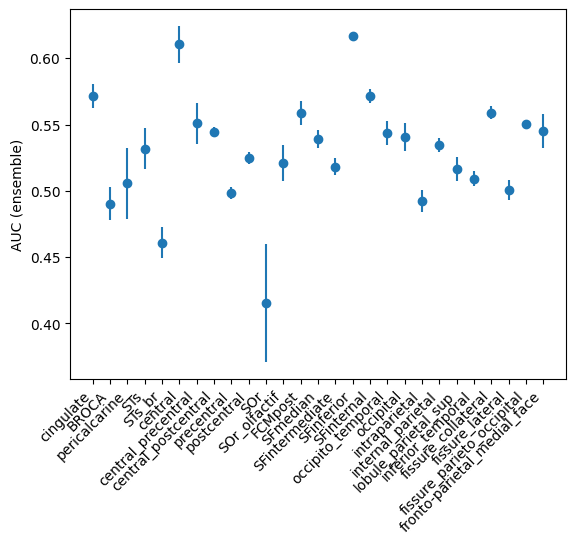

In [41]:
plt.errorbar(res.region_simple_name, res.AUC_ensemble, res.std_auc_ensemble, fmt='.', marker='o')
plt.ylabel("AUC (ensemble)")
plt.xticks(rotation=45, ha="right")

/tmp/ipykernel_919828/2997021409.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(res.region_simple_name, res.log_lr, res.std_log_lr, fmt='.', marker='o')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [Text(0, 0, 'cingulate'),
  Text(1, 0, 'BROCA'),
  Text(2, 0, 'pericalcarine'),
  Text(3, 0, 'STs'),
  Text(4, 0, 'STs_br'),
  Text(5, 0, 'central'),
  Text(6, 0, 'central_precentral'),
  Text(7, 0, 'central_postcentral'),
  Text(8, 0, 'precentral'),
  Text(9, 0, 'postcentral'),
  Text(10, 0, 'SOr'),
  Text(11, 0, 'SOr_olfactif'),
  Text(12, 0, 'FCMpost'),
  Text(13, 0, 'SFmedian'),
  Text(14, 0, 'SFintermediate'),
  Text(15, 0, 'SFinferior'),
  Text(16, 0, 'SFinternal'),
  Text(17, 0, 'occipito_temporal'),
  Text(18, 0, 'occipital'),
  Text(19, 0, 'intraparietal'),
  Text(20, 0, 'internal_parietal'),
  Text(21, 0, 'lobule_parietal_sup'),
  Text(22, 0, 'inferior_temporal'),
  Text(23, 0, 'fissure_collateral'),
  Text(24, 0, 'fissure_lateral'),
  Text(25, 0, 'fissure_parieto_occipital'),
  Text(26, 0, 'fronto-parietal_medial_face')])

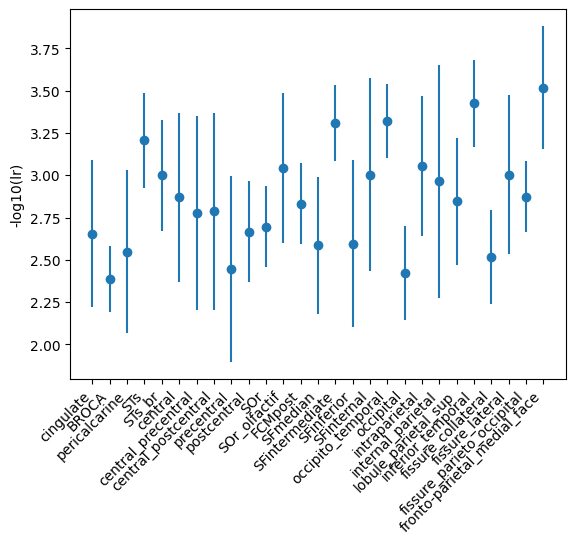

In [42]:
plt.errorbar(res.region_simple_name, res.log_lr, res.std_log_lr, fmt='.', marker='o')
plt.ylabel("-log10(lr)")
plt.xticks(rotation=45, ha="right")

/tmp/ipykernel_919828/2150178108.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(res.region_simple_name, res.AUC_ensemble, res.std_auc_ensemble, fmt='.', marker='o')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [Text(0, 0, 'cingulate'),
  Text(1, 0, 'BROCA'),
  Text(2, 0, 'pericalcarine'),
  Text(3, 0, 'STs'),
  Text(4, 0, 'STs_br'),
  Text(5, 0, 'central'),
  Text(6, 0, 'central_precentral'),
  Text(7, 0, 'central_postcentral'),
  Text(8, 0, 'precentral'),
  Text(9, 0, 'postcentral'),
  Text(10, 0, 'SOr'),
  Text(11, 0, 'SOr_olfactif'),
  Text(12, 0, 'FCMpost'),
  Text(13, 0, 'SFmedian'),
  Text(14, 0, 'SFintermediate'),
  Text(15, 0, 'SFinferior'),
  Text(16, 0, 'SFinternal'),
  Text(17, 0, 'occipito_temporal'),
  Text(18, 0, 'occipital'),
  Text(19, 0, 'intraparietal'),
  Text(20, 0, 'internal_parietal'),
  Text(21, 0, 'lobule_parietal_sup'),
  Text(22, 0, 'inferior_temporal'),
  Text(23, 0, 'fissure_collateral'),
  Text(24, 0, 'fissure_lateral'),
  Text(25, 0, 'fissure_parieto_occipital'),
  Text(26, 0, 'fronto-parietal_medial_face')])

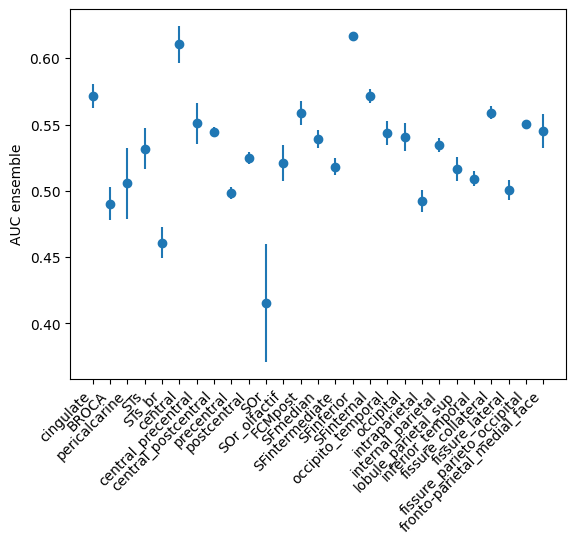

In [43]:
plt.errorbar(res.region_simple_name, res.AUC_ensemble, res.std_auc_ensemble, fmt='.', marker='o')
plt.ylabel("AUC ensemble")
plt.xticks(rotation=45, ha="right")

In [44]:
def plot_manhattan(res, region_name, ax, AUC_name, logp_AUC_name):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)

    print(res.columns)
    
    res["line"] = 2.7
    markerline, stemlines, baseline = \
        ax.stem(res[region_name],
              res[logp_AUC_name],
              basefmt= 'C0',
              linefmt=':')
    plt.setp(markerline, 'color', 'black')
    plt.setp(stemlines, 'color', 'black')
    plt.setp(baseline, 'color', 'black')
    plt.xticks(rotation=45, ha="right")
    ax.plot(res[region_name], res.line, c='black')
    ax.set_ylabel("-log10(p)", labelpad=3.0)
    # ax.set_xlabel("regions", labelpad=10.0)
    ax2 = ax.twinx()
    ax2.xaxis.set_tick_params(labelsize = labelsize)
    ax2.yaxis.set_tick_params(labelsize = labelsize)
    ax2.plot(res[region_name], res[AUC_name], c='blue')
    ax2.set_ylim([0.48,0.66])
    ax2.set_ylabel('AUC', color='b', rotation=270, labelpad=25)
    ax2.set_yticks([0.5, 0.55, 0.6, 0.65])
    ax2.spines['right'].set_color('blue')
    ax2.tick_params(axis='y', colors='blue')
    ax2.set_ylim(0.46)


Index(['region', 'region_simple_name', 'Lobe', 'AUC', 'std_auc', 'AUC-1',
       'std_auc-1', 'AUC-2', 'std_auc-2', 'AUC_narrow', 'std_auc_narrow',
       'AUC-2_narrow', 'std_auc-2_narrow', 'bdd', 'bdd_file_name',
       'AUC_criterion', 'logp_AUC', 'std_auc_criterion', 'AUC_old_criterion',
       'std_auc_old_criterion', 'AUC_best_val', 'std_auc_best_val',
       'AUC_best_model', 'std_auc_best_model', 'log_lr', 'std_log_lr',
       'logp_AUC_criterion', 'logp_AUC_old_criterion', 'logp_AUC_best_val',
       'logp_AUC_best_model', 'AUC_ensemble', 'std_auc_ensemble'],
      dtype='object')


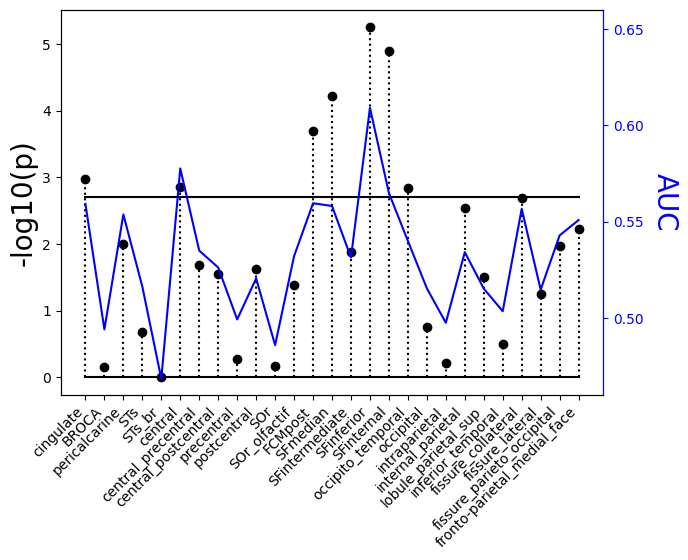

In [45]:
plt.rc('axes', labelsize=20) 
f, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_manhattan(res, "region_simple_name", ax, "AUC_criterion", "logp_AUC_criterion")
plt.show()

Index(['region', 'region_simple_name', 'Lobe', 'AUC', 'std_auc', 'AUC-1',
       'std_auc-1', 'AUC-2', 'std_auc-2', 'AUC_narrow', 'std_auc_narrow',
       'AUC-2_narrow', 'std_auc-2_narrow', 'bdd', 'bdd_file_name',
       'AUC_criterion', 'logp_AUC', 'std_auc_criterion', 'AUC_old_criterion',
       'std_auc_old_criterion', 'AUC_best_val', 'std_auc_best_val',
       'AUC_best_model', 'std_auc_best_model', 'log_lr', 'std_log_lr',
       'logp_AUC_criterion', 'logp_AUC_old_criterion', 'logp_AUC_best_val',
       'logp_AUC_best_model', 'AUC_ensemble', 'std_auc_ensemble', 'line'],
      dtype='object')


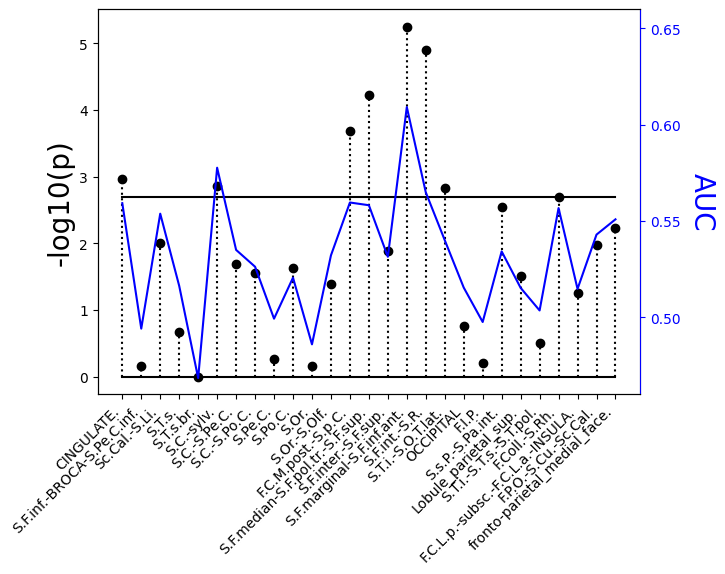

In [46]:
plt.rc('axes', labelsize=20) 
f, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_manhattan(res, "region", ax, "AUC_criterion", "logp_AUC_criterion")
plt.show()

In [47]:
res['Lobe'] = pd.Categorical(res['Lobe'], ["frontal", "temporal", "parietal", "occipital"])

In [48]:
res = res.sort_values(["Lobe", "AUC_ensemble"], ascending=[True, False])

In [49]:
res.head()

,region,region_simple_name,Lobe,AUC,std_auc,AUC-1,std_auc-1,AUC-2,std_auc-2,AUC_narrow,...,std_auc_best_model,log_lr,std_log_lr,logp_AUC_criterion,logp_AUC_old_criterion,logp_AUC_best_val,logp_AUC_best_model,AUC_ensemble,std_auc_ensemble,line
15,S.F.marginal-S.F.inf.ant.,SFinferior,frontal,0.609,0.009,0.548,0.054,0.609,0.009,NaN,...,0.061147,2.593849,0.494544,5.250836,1.223397,5.250836,1.045514,0.616450,0.002066,2.7
5,S.C.-sylv.,central,frontal,0.578,0.026,0.578,0.026,0.585,0.015,NaN,...,0.011038,2.869598,0.500598,2.855748,2.855748,3.976741,4.386128,0.610390,0.013871,2.7
0,CINGULATE.,cingulate,frontal,0.559,0.019,0.560,0.019,0.546,0.028,0.553,...,0.039295,2.653998,0.434632,2.970499,2.970499,2.005764,1.895694,0.571717,0.008981,2.7
16,S.F.int.-S.R.,SFinternal,frontal,0.565,0.007,0.565,0.007,0.488,0.051,NaN,...,0.031525,3.004289,0.569990,4.901559,4.901559,0.159768,1.756349,0.571429,0.005091,2.7
6,S.C.-S.Pe.C.,central_precentral,frontal,0.535,0.026,0.547,0.024,0.535,0.026,0.552,...,0.016683,2.776188,0.574945,1.683537,2.208063,1.683537,2.861683,0.550938,0.015470,2.7


In [50]:
def compute_logp_df_ensemble(df):
    return compute_logp(df["AUC_ensemble"], df["std_auc_ensemble"])

In [58]:
res.head()

,region,region_simple_name,Lobe,AUC,std_auc,AUC-1,std_auc-1,AUC-2,std_auc-2,AUC_narrow,...,std_auc_best_model,log_lr,std_log_lr,logp_AUC_criterion,logp_AUC_old_criterion,logp_AUC_best_val,logp_AUC_best_model,AUC_ensemble,std_auc_ensemble,line
15,S.F.marginal-S.F.inf.ant.,SFmarginal,frontal,0.609,0.009,0.548,0.054,0.609,0.009,NaN,...,0.061147,2.593849,0.494544,5.250836,1.223397,5.250836,1.045514,0.616450,0.002066,2.7
5,S.C.-sylv.,central,frontal,0.578,0.026,0.578,0.026,0.585,0.015,NaN,...,0.011038,2.869598,0.500598,2.855748,2.855748,3.976741,4.386128,0.610390,0.013871,2.7
0,CINGULATE.,cingulate,frontal,0.559,0.019,0.560,0.019,0.546,0.028,0.553,...,0.039295,2.653998,0.434632,2.970499,2.970499,2.005764,1.895694,0.571717,0.008981,2.7
16,S.F.int.-S.R.,SFinternal,frontal,0.565,0.007,0.565,0.007,0.488,0.051,NaN,...,0.031525,3.004289,0.569990,4.901559,4.901559,0.159768,1.756349,0.571429,0.005091,2.7
6,S.C.-S.Pe.C.,central_precentral,frontal,0.535,0.026,0.547,0.024,0.535,0.026,0.552,...,0.016683,2.776188,0.574945,1.683537,2.208063,1.683537,2.861683,0.550938,0.015470,2.7


In [59]:
res.region_simple_name.tolist()

['SFmarginal',
 'central',
 'cingulate',
 'SFinternal',
 'central_precentral',
 'fronto-parietal_medial_face',
 'SFmedian',
 'SOr_olfactif',
 'SFintermediate',
 'precentral',
 'BROCA',
 'SOr',
 'fissure_collateral',
 'occipito_temporal',
 'STs',
 'inferior_temporal',
 'fissure_lateral',
 'STs_br',
 'FCMpost',
 'central_postcentral',
 'internal_parietal',
 'postcentral',
 'lobule_parietal_sup',
 'intraparietal',
 'fissure_parieto_occipital',
 'occipital',
 'pericalcarine']

In [60]:
res['logp_AUC_ensemble'] = res.apply(compute_logp_df_ensemble, axis=1)
res['region_simple_name'].replace({"SFinferior":"SFmarginal"}, inplace=True)
res = res[res["region_simple_name"].str.contains("fronto-parietal_medial_face") == False] 
res.region_simple_name.tolist()

['SFmarginal',
 'central',
 'cingulate',
 'SFinternal',
 'central_precentral',
 'SFmedian',
 'SOr_olfactif',
 'SFintermediate',
 'precentral',
 'BROCA',
 'SOr',
 'fissure_collateral',
 'occipito_temporal',
 'STs',
 'inferior_temporal',
 'fissure_lateral',
 'STs_br',
 'FCMpost',
 'central_postcentral',
 'internal_parietal',
 'postcentral',
 'lobule_parietal_sup',
 'intraparietal',
 'fissure_parieto_occipital',
 'occipital',
 'pericalcarine']

Index(['region', 'region_simple_name', 'Lobe', 'AUC', 'std_auc', 'AUC-1',
       'std_auc-1', 'AUC-2', 'std_auc-2', 'AUC_narrow', 'std_auc_narrow',
       'AUC-2_narrow', 'std_auc-2_narrow', 'bdd', 'bdd_file_name',
       'AUC_criterion', 'logp_AUC', 'std_auc_criterion', 'AUC_old_criterion',
       'std_auc_old_criterion', 'AUC_best_val', 'std_auc_best_val',
       'AUC_best_model', 'std_auc_best_model', 'log_lr', 'std_log_lr',
       'logp_AUC_criterion', 'logp_AUC_old_criterion', 'logp_AUC_best_val',
       'logp_AUC_best_model', 'AUC_ensemble', 'std_auc_ensemble', 'line',
       'logp_AUC_ensemble'],
      dtype='object')


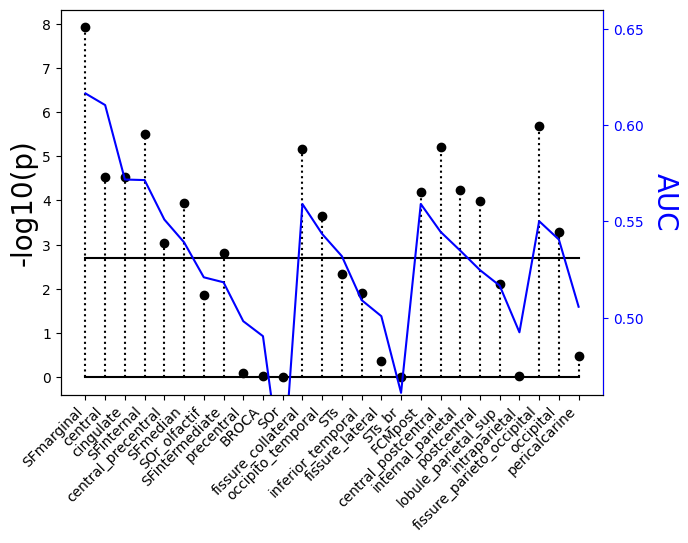

In [61]:
plt.rc('axes', labelsize=20) 
f, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_manhattan(res, "region_simple_name", ax, "AUC_ensemble", "logp_AUC_ensemble")
plt.show()

In [62]:
def plot_bar(res, region_name, ax, AUC_name, std_auc_name, AUC2_name, std_auc2_name, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)

    # ax.errorbar(res[region_name], res[AUC_name], res[std_auc_name], fmt='s', color='black')
    ax.scatter(res[region_name], res[AUC_name], marker='s', color='black')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
    ax.axhline(y=0.5, color='black', linestyle='-')
    ax.bar(res[region_name], res[AUC2_name], fill=False)
    ax.errorbar(res[region_name], res[AUC2_name], res[std_auc2_name], fmt='.', color='black')
    if visible:
        ax.set_ylabel("AUC ensemble")
    else:
        ax.get_yaxis().set_ticks([])
    ax.set_ylim((0.45, 0.63))
    ax.set_title(title)


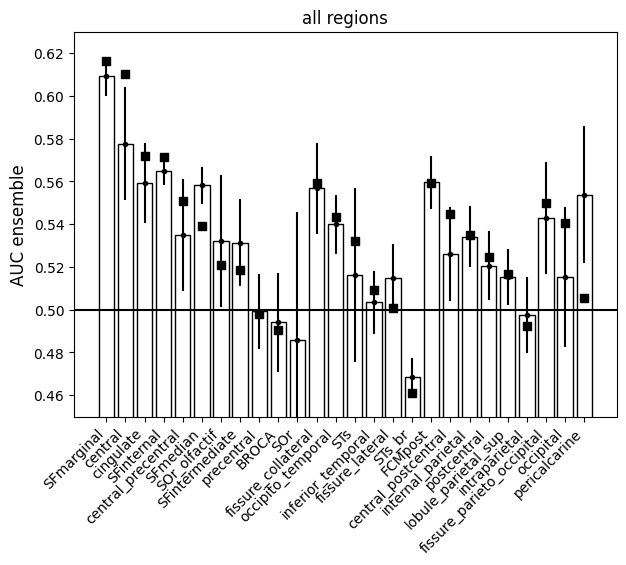

In [63]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_bar(res, "region_simple_name", ax, "AUC_ensemble", "std_auc_ensemble", "AUC_criterion", "std_auc_criterion", True, "all regions")
plt.show()

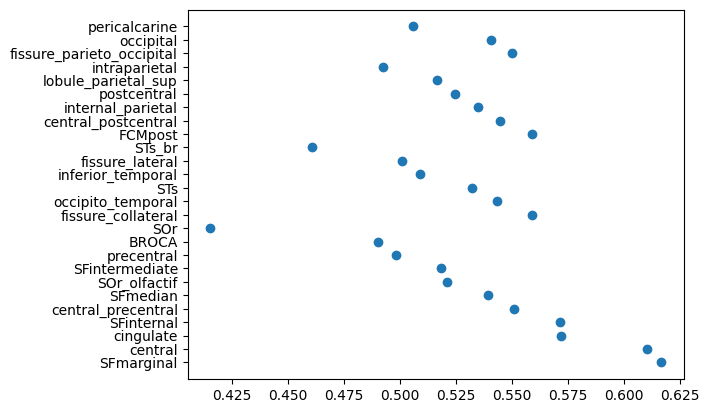

In [68]:
plt.scatter(res['AUC_ensemble'], res['region_simple_name'])

In [69]:
lobes = ['frontal', 'temporal', 'parietal', 'occipital']
lengths = []
for lobe in lobes:
    length = len(res[res.Lobe == lobe])
    lengths.append(length)
lengths = [l/sum(lengths) for l in lengths]
print(lengths)

[0.4230769230769231, 0.23076923076923078, 0.23076923076923078, 0.11538461538461539]


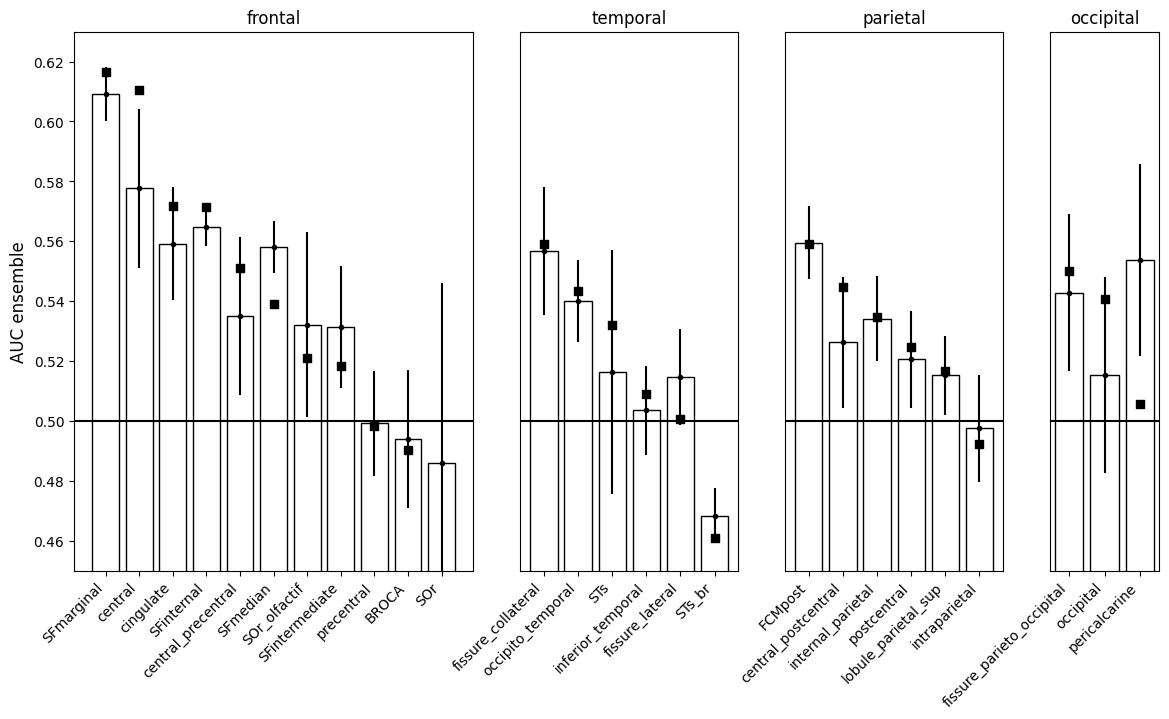

In [70]:
plt.rc('axes', labelsize=12) 
f, axs = plt.subplots(1, 4, figsize=(14, 7), gridspec_kw=dict(width_ratios=lengths))
for i in range(4):
    visible = True if i==0 else False
    plot_bar(res[res['Lobe']==lobes[i]], "region_simple_name", axs[i], "AUC_ensemble", "std_auc_ensemble", "AUC_criterion", "std_auc_criterion", visible, lobes[i])

plt.show()

In [124]:
def plot_horizontal(res, region_name, ax, AUC_name, std_auc_name, AUC2_name, std_auc2_name, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=AUC_name, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=0.5, color='black', linestyle='-')
    ax.barh(res[region_name], res[AUC2_name], fill=True, color='lightgray')
    ax.errorbar(res[AUC_name], res[region_name], xerr=res[std_auc_name], fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    ax.set_xlim((0.45, 0.63))
    ax.set_title(title)


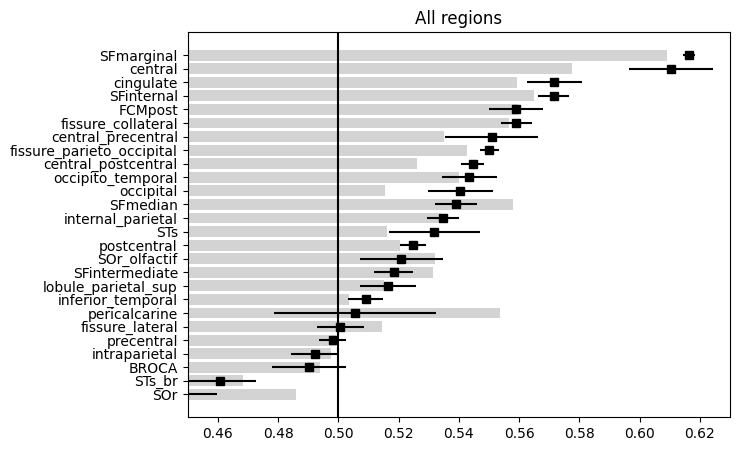

In [142]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(7, 5))
res["region_double_name"] = res["region_simple_name"]
plot_horizontal(res, "region_double_name", ax, "AUC_ensemble", "std_auc_ensemble", "AUC_criterion", "std_auc_criterion", True, "All regions")
plt.show()

# Schizophrene

In [143]:
path_res_schiz = "/neurospin/dico/agaudin/Runs/09_new_repo/Output/grid_searches/step3/all_with_rethreshold_occipital/summary_results_schiz_per_regions.csv"
res_schiz = pd.read_csv(path_res_schiz)
res_schiz.head()

,Unnamed: 0,best_test_all_mean_auc,best_test_mean_auc,best_test_mean_std_auc,best_test_ensemble_mean_auc,best_test_ensemble_std_auc
0,BROCA,0.528239,0.515282,0.025677,0.525202,0.012605
1,cingulate,0.547267,0.551791,0.044994,0.546401,0.010937
2,FCMpost,0.538357,0.500535,0.040174,0.536164,0.015065
3,FIP,0.547569,0.519511,0.029018,0.544450,0.006581
4,fissure_collateral,0.572637,0.554309,0.032469,0.574076,0.009486


In [144]:
type(res_schiz)

pandas.core.frame.DataFrame

In [145]:
res_schiz = res_schiz.rename(columns={'Unnamed: 0': 'region_simple_name'}) 
res_schiz.head()

,region_simple_name,best_test_all_mean_auc,best_test_mean_auc,best_test_mean_std_auc,best_test_ensemble_mean_auc,best_test_ensemble_std_auc
0,BROCA,0.528239,0.515282,0.025677,0.525202,0.012605
1,cingulate,0.547267,0.551791,0.044994,0.546401,0.010937
2,FCMpost,0.538357,0.500535,0.040174,0.536164,0.015065
3,FIP,0.547569,0.519511,0.029018,0.544450,0.006581
4,fissure_collateral,0.572637,0.554309,0.032469,0.574076,0.009486


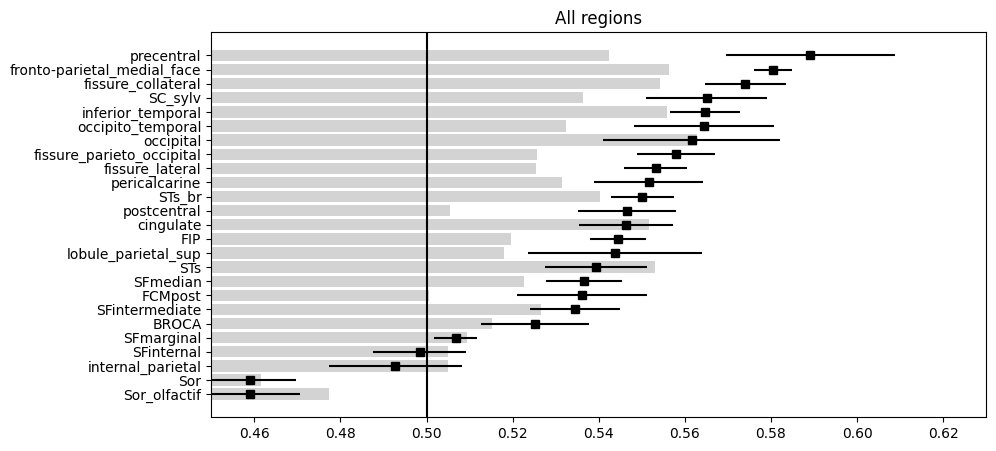

In [146]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_horizontal(res_schiz, "region_simple_name", ax, "best_test_ensemble_mean_auc", "best_test_ensemble_std_auc", "best_test_mean_auc", "best_test_mean_std_auc", True, "All regions")
plt.show()